# Spatial relationships and operations
based on scipy2018-geospatial

## goals of the tutorial
- load csv files as geodataframe
- spatial projection conversion
- spatial relationships 
- spatial joins
- spatial operations

**based on the open data of:**
- [ISTAT](https://www.istat.it/it/archivio/222527) Italian National Institute of Statistic 
- [MIBACT](https://anagrafe.iccu.sbn.it/it/open-data/) Italian Ministery of Cultural Heritage


### requirements
- python knowledge
- pandas
- previous lesson

### status 
*"Spatial is Special"*

---

# SETUP

## We need a OS with the rtree index
needed for geopandas spatial relationships

In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

In [2]:
!pip install geopandas

**special issue**:<br/>investigate the data with pandas profile!!!


In [3]:
!pip install -U pandas-profiling

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.9.0)


In [4]:
import pandas as pd
import pandas_profiling 
import geopandas as gpd

## data setup
geopackage with the administrative units of italy

In [5]:
!wget https://github.com/napo/geospatial_course_unitn/raw/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg

--2020-10-10 20:22:15--  https://github.com/napo/geospatial_course_unitn/raw/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg [following]
--2020-10-10 20:22:15--  https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/data/administrative_units_italy_2020/istat_administrative_units_2020.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23396352 (22M) [application/octet-stream]
Saving to: ‘ista

In [6]:
macroregions = gpd.read_file("istat_administrative_units_2020.gpkg",layer="macroregions")

In [7]:
regions = gpd.read_file("istat_administrative_units_2020.gpkg",layer="regions")

In [8]:
provincies = gpd.read_file("istat_administrative_units_2020.gpkg",layer="provincies")

In [9]:
municipalities = gpd.read_file("istat_administrative_units_2020.gpkg",layer="municipalities")

In [10]:
macroregions

COD_RIP     DEN_RIP                                           geometry
0        1  Nord-Ovest  MULTIPOLYGON (((459010.230 4906246.581, 458965...
1        2    Nord-Est  MULTIPOLYGON (((865462.248 5073771.939, 865061...
2        3      Centro  MULTIPOLYGON (((675849.390 4700249.700, 675886...
3        4         Sud  MULTIPOLYGON (((930273.425 4714737.743, 930271...
4        5       Isole  MULTIPOLYGON (((1078691.643 4256925.304, 10793...

# Investigate the dataset of the italian public libraries
## from a dataframe to a geodataframe

we have a csv file with some points of interest where the coordinates are expressed in a column for the longitude and another for the latitude.

### the dataset of the public libraries
The italian Ministery of Cultural Heritage offers the open data with the location of public libraries in Italy<br/>
https://anagrafe.iccu.sbn.it/it/open-data/

here the link for the [download](http://opendata.anagrafe.iccu.sbn.it/territorio.zip)


This dataset is NOT archived in a spatial format.

**load the data with pandas**


In [11]:
libraries = pd.read_csv('http://opendata.anagrafe.iccu.sbn.it/territorio.zip', compression='zip', sep=';')

In [12]:
libraries.head(5)

codice-isil  ...                                                url
0   IT-AG0001  ...                                                NaN
1   IT-AG0005  ...  http://www.archiviodistatoagrigento.benicultur...
2   IT-AG0006  ...                                                NaN
3   IT-AG0007  ...  http://www.opacagrigento.it/biblioteche/bi_1.html
4   IT-AG0008  ...                                                NaN

[5 rows x 17 columns]

### special investigation with pandas profile

In [13]:
libraries.profile_report()

In [14]:
libraries.shape

(11725, 17)

In [15]:
libraries.head(5)

codice-isil  ...                                                url
0   IT-AG0001  ...                                                NaN
1   IT-AG0005  ...  http://www.archiviodistatoagrigento.benicultur...
2   IT-AG0006  ...                                                NaN
3   IT-AG0007  ...  http://www.opacagrigento.it/biblioteche/bi_1.html
4   IT-AG0008  ...                                                NaN

[5 rows x 17 columns]

In [16]:
libraries.columns

Index(['codice-isil', 'codice-sbn', 'denominazione', 'indirizzo', 'frazione',
       'cap', 'comune', 'codice istat comune', 'provincia', 'regione',
       'codice istat provincia', 'latitudine', 'longitudine', 'telefono',
       'fax', 'email', 'url'],
      dtype='object')

### information about the columns
**codice-isil**<br/>
alphanumeric code for the International Standard Identifier for Libraries and related organizations - primary key

**latitudine**<br/>
the latitude in WGS84

**longitudine**<br/>
the longitude in WGS84

**provincia**<br/>
name of the italian province



... some informations from the datasets of ISTAT

In [17]:
macroregions

COD_RIP     DEN_RIP                                           geometry
0        1  Nord-Ovest  MULTIPOLYGON (((459010.230 4906246.581, 458965...
1        2    Nord-Est  MULTIPOLYGON (((865462.248 5073771.939, 865061...
2        3      Centro  MULTIPOLYGON (((675849.390 4700249.700, 675886...
3        4         Sud  MULTIPOLYGON (((930273.425 4714737.743, 930271...
4        5       Isole  MULTIPOLYGON (((1078691.643 4256925.304, 10793...

list of the regions in the North-East Italy macroregion (COD_RIP = 2)

In [18]:
regions[regions.COD_RIP==2].DEN_REG.unique()

array(['Veneto', 'Trentino-Alto Adige', 'Friuli Venezia Giulia',
       'Emilia-Romagna'], dtype=object)

list of the provincies in the North-East Italy macroregion (COD_RIP = 2)

In [19]:
provincies[provincies.COD_RIP==2].DEN_UTS.unique()

array(['Bolzano', 'Belluno', 'Treviso', 'Venezia', 'Trento', 'Verona',
       'Vicenza', 'Udine', 'Gorizia', 'Trieste', 'Padova', 'Rovigo',
       'Modena', 'Bologna', 'Piacenza', 'Parma', "Reggio nell'Emilia",
       'Ferrara', 'Ravenna', "Forli'-Cesena", 'Rimini', 'Pordenone'],
      dtype=object)

the provincies listed in the libraries dataset

In [20]:
libraries.provincia.unique()

array(['Agrigento', 'Alessandria', 'Ancona',
       "Valle d'Aosta/Vallée d'Aoste", 'Fermo', 'Ascoli Piceno',
       'Macerata', "L'Aquila", 'Arezzo', 'Asti', 'Avellino', 'Bari',
       'Barletta-Andria-Trani', 'Bergamo', 'Biella', 'Belluno', 'Udine',
       'Benevento', 'Bologna', 'Brindisi', 'Brescia', 'Bolzano/Bozen',
       'Sud Sardegna', 'Cagliari', 'Campobasso', 'Caserta', 'Salerno',
       'Chieti', 'Caltanissetta', 'Cuneo', 'Como', 'Cremona', 'Cosenza',
       'Catania', 'Catanzaro', 'Enna', 'Forlì-Cesena', 'Ferrara',
       'Foggia', 'Firenze', 'Frosinone', 'Genova', 'Gorizia', 'Grosseto',
       'Imperia', 'Isernia', 'Crotone', 'Lecco', 'Lecce', 'Livorno',
       'Lodi', 'Latina', 'Lucca', 'Monza e della Brianza', 'Messina',
       'Milano', 'Mantova', 'Modena', 'Massa-Carrara', 'Matera', 'Napoli',
       'Novara', 'Nuoro', 'Oristano', 'Sassari', 'Palermo', 'Piacenza',
       'Padova', 'Pescara', 'Perugia', 'Pisa', 'Pordenone', 'Prato',
       'Parma', 'Pistoia', 'Pesaro e U

we can use the columns *latitudine* and *longitudine* to plot a map

note:<br>
the **separator** of the decimal is with the **comma** and not with the **dot**.<br/>
We need to change it!

In [21]:
libraries.latitudine

0               37,3361677
1         37,3221644312329
2               37,3137125
3               37,3095818
4               37,4050904
               ...        
11720           38,6775708
11721           38,7498779
11722           38,6740584
11723    38,67213965194707
11724    38,67344181930883
Name: latitudine, Length: 11725, dtype: object

In [22]:
lat="37,3361677"

In [23]:
pd.to_numeric(libraries.latitudine.str.replace(",","."))

0        37.336168
1        37.322164
2        37.313713
3        37.309582
4        37.405090
           ...    
11720    38.677571
11721    38.749878
11722    38.674058
11723    38.672140
11724    38.673442
Name: latitudine, Length: 11725, dtype: float64

In [24]:
libraries['latitudine'] = pd.to_numeric(libraries.latitudine.str.replace(",","."))
libraries.longitudine = pd.to_numeric(libraries.longitudine.str.replace(",","."))

In [25]:
libraries.head(3)

codice-isil  ...                                                url
0   IT-AG0001  ...                                                NaN
1   IT-AG0005  ...  http://www.archiviodistatoagrigento.benicultur...
2   IT-AG0006  ...                                                NaN

[3 rows x 17 columns]

We also to check the presence of NULL values

In [26]:
libraries.latitudine.isnull().values.sum()

74

we can't work with the rows with NULL values

In [27]:
libraries = libraries[libraries.latitudine.isnull() == False]

now we are ready to create the geodataframe.
the operation are:
- creation of a geometry column based on the WKT syntax
- transform the DataFrame in GeoDataFrame

GeoDataFrame [constructor](https://geopandas.org/reference/geopandas.GeoDataFrame.html):
* a dataframe (or dictionary)
* the CRS
* a geometry field expressed in WKT (eg. POINT (1,3)) 



In [28]:
geo_libraries = gpd.GeoDataFrame(
    libraries,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(libraries.longitudine, libraries.latitudine))

In [29]:
type(geo_libraries)

geopandas.geodataframe.GeoDataFrame

... and now we can plot the map!!!

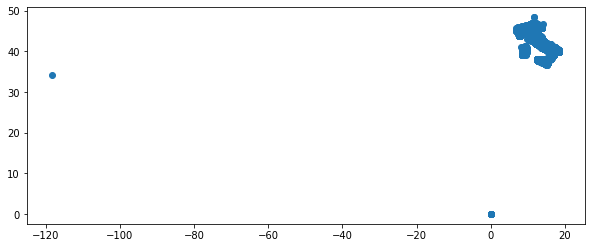

In [30]:
geo_libraries.plot(figsize=(10,10))

In [31]:
geo_libraries[geo_libraries.latitudine==0]

codice-isil codice-sbn  ...                        url                 geometry
2474   IT-CB0065        NaN  ...                        NaN  POINT (0.00000 0.00000)
3123   IT-CS0066        NaN  ...                        NaN  POINT (0.00000 0.00000)
3737   IT-FI0114        NaN  ...                        NaN  POINT (0.00000 0.00000)
4014   IT-FR0137        NaN  ...                        NaN  POINT (0.00000 0.00000)
4461   IT-LE0044        NaN  ...                        NaN  POINT (0.00000 0.00000)
...          ...        ...  ...                        ...                      ...
8378   IT-RM0535      RMGBI  ...                        NaN  POINT (0.00000 0.00000)
8696   IT-RM1213        NaN  ...                        NaN  POINT (0.00000 0.00000)
8697   IT-RM1215        NaN  ...                        NaN  POINT (0.00000 0.00000)
8846   IT-RM1518      RMSAY  ...          www.iccave.gov.it  POINT (0.00000 0.00000)
9089   IT-RO0021      ROVFI  ...  www.comune.ficarolo.ro.it  POINT (0.00000 0.00000)

[61 rows x 18 columns]

there are some **mistakes**!!!

we plot the dots over the macro-regions of Italy

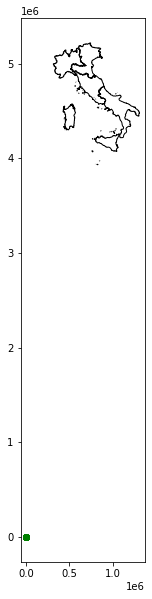

In [32]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_libraries.plot(ax=ax,color="green")

In [33]:
macroregions.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°E to 12°E - by country
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
geo_libraries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**ERROR**!<br/>
We need to use the same projection!!!<br/>
The projection used in our geodataframe of ISTAT is EPSG:32632

In [35]:
macroregions.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°E to 12°E - by country
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

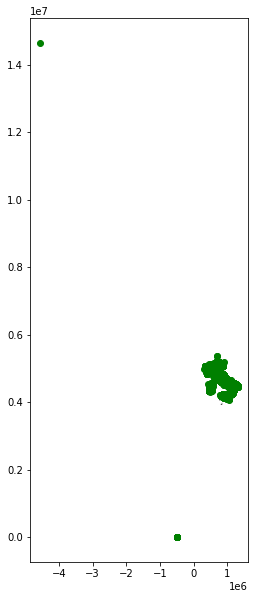

In [36]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_libraries.to_crs(epsg=32632).plot(ax=ax,color="green")

## identify the boundary of the two datasets
#### calculate  the bounds

In [37]:
italy_bounds = macroregions.to_crs(epsg=4326).bounds  #we will check this in WGS84

In [38]:
italy_bounds

minx       miny       maxx       maxy
0   6.626621  43.776034  11.427673  46.635187
1   9.198037  43.731924  13.918853  47.091784
2   9.686700  40.784734  14.027645  44.472707
3  13.018488  37.915754  18.520382  42.895081
4   8.133825  35.493692  15.652935  41.313321

**italy**<br/>
coordinates of the boundary<br/>
bottom left point => minimum value for minx and for miny<br/>
top right point => maximum value for maxx and for maxy<br/>

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/boudingbox.png)

``` 
Bottom Left Point: POINT (minx, miny)
Top Right Point: POINT (maxx, maxy)
```

In [39]:
print(italy_bounds.minx.min(),italy_bounds.miny.min(),italy_bounds.maxx.max(),italy_bounds.maxy.max())

6.626621368537681 35.49369193551142 18.520381599098922 47.09178374646217


**libraries**

In [40]:
print(geo_libraries.bounds.minx.min(),geo_libraries.bounds.miny.min(),geo_libraries.bounds.maxx.max(),geo_libraries.bounds.maxy.max())

-118.241653 0.0 18.491521 48.426567


the bounding box of the libraries is bigger as the bouding box of Italy

---
# Spatial relationships 
## how two spatial objects relate to each other 

![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

## Relationships between individual objects

Eg.<br>
Is this library located in the north-east Italian macro-region?

we need the north-east italian macro-region in wgs84

In [41]:
macroregions

COD_RIP     DEN_RIP                                           geometry
0        1  Nord-Ovest  MULTIPOLYGON (((459010.230 4906246.581, 458965...
1        2    Nord-Est  MULTIPOLYGON (((865462.248 5073771.939, 865061...
2        3      Centro  MULTIPOLYGON (((675849.390 4700249.700, 675886...
3        4         Sud  MULTIPOLYGON (((930273.425 4714737.743, 930271...
4        5       Isole  MULTIPOLYGON (((1078691.643 4256925.304, 10793...

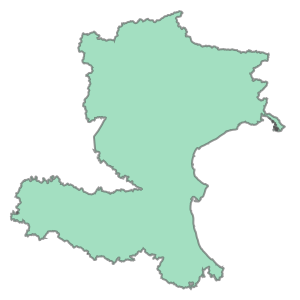

In [42]:
macroregions.geometry[1]

In [43]:
northeast = macroregions.to_crs(epsg=4326).geometry[1]

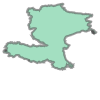

In [44]:
northeast

## let's start with just one point



so we will choose a library in Trento (north east italy)

In [45]:
geo_libraries[geo_libraries.comune == 'Trento'].head(5) #the first 5 libraries

codice-isil  ...                   geometry
9910   IT-TN0121  ...  POINT (11.12079 46.06975)
9911   IT-TN0122  ...  POINT (11.13470 46.06541)
9912   IT-TN0123  ...  POINT (11.11964 46.06676)
9913   IT-TN0125  ...  POINT (11.10971 46.08832)
9914   IT-TN0126  ...  POINT (11.12369 46.06070)

[5 rows x 18 columns]

we choose the library with *codice-isil* equals to *IT-TN0121* and extract only the geometry

In [46]:
public_library_of_trento = geo_libraries[geo_libraries['codice-isil'] == 'IT-TN0121'].geometry.values[0]

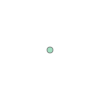

In [47]:
public_library_of_trento

## within relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;it's the point inside the area?

In [48]:
public_library_of_trento.within(northeast)

True

## contain relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;does the area contain the point?

In [49]:
northeast.contains(public_library_of_trento)

True

we can iterate the operation for each point

_very slow!_

In [50]:
libraries_northeast = geo_libraries[geo_libraries.within(northeast)]
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [51]:
libraries_northeast.shape

(2808, 18)

In [52]:
libraries_northeast.regione.unique()

array(['VENETO', 'FRIULI-VENEZIA GIULIA', 'EMILIA-ROMAGNA',
       'TRENTINO-ALTO ADIGE/SÜDTIROL', 'PIEMONTE', 'CALABRIA'],
      dtype=object)

**PIEMONTE??? CALABRIA???**

In [53]:
regions[regions.COD_RIP==2].DEN_REG.unique()

array(['Veneto', 'Trentino-Alto Adige', 'Friuli Venezia Giulia',
       'Emilia-Romagna'], dtype=object)

In [54]:
libraries_northeast[libraries_northeast.regione == 'PIEMONTE']

codice-isil codice-sbn  ...  url                   geometry
2707   IT-CN0021        NaN  ...  NaN  POINT (11.61716 45.52376)

[1 rows x 18 columns]

In [55]:
libraries_northeast[libraries_northeast.regione == 'CALABRIA']

codice-isil codice-sbn  ...  url                   geometry
3146   IT-CS0113        NaN  ...  NaN  POINT (10.61814 44.53957)

[1 rows x 18 columns]

In [56]:
point = libraries_northeast[libraries_northeast['codice-isil']=='IT-CS0113'].geometry.values[0]

In [57]:
regions[regions.to_crs(epsg=4326).contains(point)]

COD_RIP  ...                                           geometry
7        2  ...  MULTIPOLYGON (((572180.307 4994427.402, 572265...

[1 rows x 4 columns]

In [58]:
provincies[provincies.to_crs(epsg=4326).contains(point)]

COD_RIP  ...                                           geometry
36        2  ...  MULTIPOLYGON (((636319.374 4982990.190, 636334...

[1 rows x 11 columns]

In [59]:
municipalities[municipalities.to_crs(epsg=4326).contains(point)]

COD_RIP  ...                                           geometry
2713        2  ...  MULTIPOLYGON (((630696.410 4933281.353, 631789...

[1 rows x 11 columns]

We can assume that the record is **WRONG**!!!



---


<div class="alert alert-info" style="font-size:120%">
<b>REFERENCE</b>: <br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):
<ul>
    <li>`equals`</li>
<li>`contains`</li>
<li>`crosses`</li>
<li>`disjoint`</li>
<li>`intersects`</li>
<li>`overlaps`</li>
<li>`touches`</li>
<li>`within`</li>
<li>`covers`</li>
</ul>


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.


See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations. 

# Spatial Joins

You can create a join like the usual [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) between pandas dataframe by using a spatial relationship with the function [geopandas.sjoin](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html)

In [60]:
libraries_and_macroregions = gpd.sjoin(macroregions.to_crs(epsg=4326), 
                          geo_libraries, how='inner', op='contains', lsuffix='macroregions_', rsuffix='libraries_')
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [61]:
libraries_and_macroregions.columns

Index(['COD_RIP', 'DEN_RIP', 'geometry', 'index_libraries_', 'codice-isil',
       'codice-sbn', 'denominazione', 'indirizzo', 'frazione', 'cap', 'comune',
       'codice istat comune', 'provincia', 'regione', 'codice istat provincia',
       'latitudine', 'longitudine', 'telefono', 'fax', 'email', 'url'],
      dtype='object')

In [62]:
libraries_and_macroregions.shape

(11553, 21)

In [63]:
libraries_and_macroregions.head(5)

COD_RIP  ...                                                url
0        1  ...           http://www.comune.borno.bs.it/biblioteca
0        1  ...                                                NaN
0        1  ...  https://opac.provincia.brescia.it/library/bibl...
0        1  ...                                                NaN
0        1  ...  http://www.comune.niardo.bs.it/pages/amministr...

[5 rows x 21 columns]

In [64]:
libraries_and_macroregions.geom_type.unique()

array(['MultiPolygon'], dtype=object)

... and now you can investigate the new geodataframe

In [65]:
total_libraries_for_macroregion = libraries_and_macroregions.groupby(['DEN_RIP']).size().to_frame('size').reset_index().sort_values(['size', 'DEN_RIP'], ascending=False)

In [66]:
total_libraries_for_macroregion.rename(columns={'size':'total','DEN_RIP':'macroregion'},inplace=True)

In [67]:
total_libraries_for_macroregion

macroregion  total
3  Nord-Ovest   3257
2    Nord-Est   2808
0      Centro   2331
4         Sud   2053
1       Isole   1104

In [68]:
total_libraries_for_macroregion.set_index('macroregion',inplace=True)

In [69]:
total_libraries_for_macroregion

total
macroregion       
Nord-Ovest    3257
Nord-Est      2808
Centro        2331
Sud           2053
Isole         1104

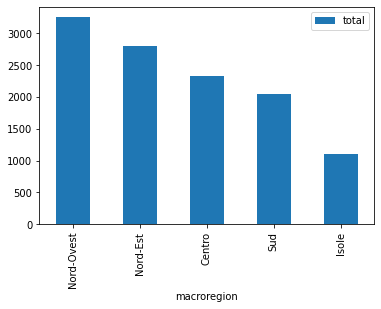

In [70]:
total_libraries_for_macroregion.plot.bar()


<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN </b>= *transferring attributes from one layer to another based on their spatial relationship*<br/>

Different parts of this operations:
<ul>
    <li>The GeoDataFrame to which we want add information</li>
    <li>The GeoDataFrame that contains the information we want to add</li>
    <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
    <li>The type of join: left or inner join</li>
</ul>


---
# Spatial operations 
GeoPandas provide analysis methods that return new geometric objects (based on shapely)

See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

## Es. buffer
*object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)*

    Returns an approximate representation of all points within a given distance of the this geometric object.

In [71]:
public_library_of_trento_32632 = geo_libraries[geo_libraries['codice-isil'] == 'IT-TN0121'].to_crs(32632).geometry.values[0]

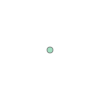

In [72]:
public_library_of_trento_32632

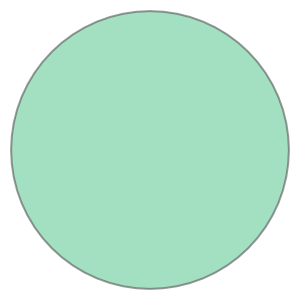

In [73]:
public_library_of_trento_32632.buffer(9000) # a circle with a ray of 9000 meters

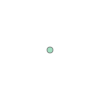

In [74]:
public_library_of_trento_32632

## Es. simplify

*object.simplify(tolerance, preserve_topology=True)*

    Returns a simplified representation of the geometric object.


In [75]:
northeast_geometry = macroregions[macroregions.COD_RIP==2].geometry.values[0]

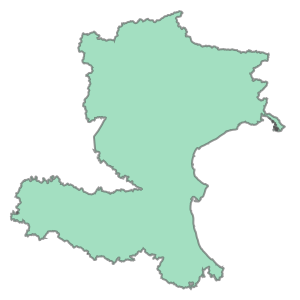

In [76]:
northeast_geometry

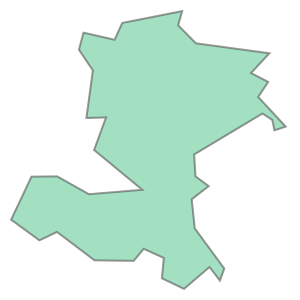

In [77]:
northeast_geometry.simplify(10000,preserve_topology=False)

## Es. symmetric_difference
*object.symmetric_difference(other)*

    Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object.


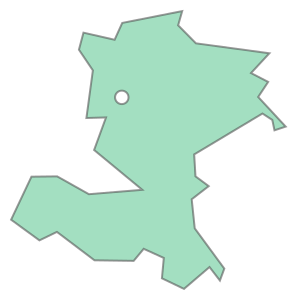

In [78]:
northeast_geometry.simplify(10000,preserve_topology=False).symmetric_difference(public_library_of_trento_32632.buffer(9000))

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.readthedocs.io/en/latest/reference.html">http://geopandas.readthedocs.io/en/latest/reference.html</a></li>
    </ul>



---
# Aggregation with dissolve

Spatial data are often more granular than we need. For example, we have the data of the macro-regions but we don't have a geometry with the border of Italy.

If we have a columns to operate a *groupby* we can solve it but to create the geometry we need the function *dissolve*.



In [79]:
macroregions['nation']='italy'

In [80]:
macroregions

COD_RIP  ... nation
0        1  ...  italy
1        2  ...  italy
2        3  ...  italy
3        4  ...  italy
4        5  ...  italy

[5 rows x 4 columns]

In [81]:
italy = macroregions[['nation', 'geometry']]

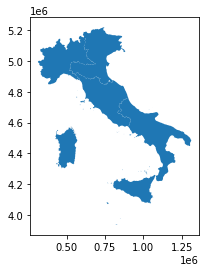

In [82]:
italy.plot()

In [83]:
%time
italy = italy.to_crs(epsg=4326).dissolve(by='nation')


CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 18.6 µs


In [84]:
italy

geometry
nation                                                   
italy   MULTIPOLYGON (((17.96930 40.05419, 17.96937 40...

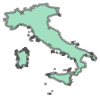

In [85]:
italy.geometry[0]

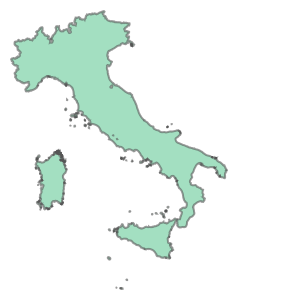

In [86]:
italy.to_crs(epsg=32632).geometry[0]

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

dissolve can be thought of as doing three things: (a) it **dissolves** all the geometries within a given group together into a single geometric feature (using the *unary_union* method), and (b) it **aggregates** all the rows of data in a group using *groupby.aggregate()*, and (c) it **combines** those two results.
    
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.org/aggregation_with_dissolve.html">http://geopandas.org/aggregation_with_dissolve.html</a></li>
 </ul>

---
# Exercise
- create the geodataframe of the [pharmacies of Trentino](http://servizi.apss.tn.it/opendata/FARM001.csv)
- count the total of phamarcies for each muncipality of Trentino
- list the municipalities bordering with Trento
- create the macroarea of all the municipalities bordering with Trento
- for each pharmacy contained in the macro-area, calculate how many libraries are within a 500m radius
- creates a polygon that contains all the pharmacies within a 2km radius of the Trento public library
- save the polygon in geopackage with the attribute "description" with value "area of the pharmacies 2km from the Trento public libray"
---